In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the already trained 200sr_20tau baseline model.
import tensorflow as tf
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/EfficientNet&Resnet_saved_models_without_fine_tuning/dataset_200sr_20tau")

In [ ]:
# Prepare dataset
train_dir = "/content/drive/MyDrive/dataset_Transfer_learning(20tau)/dataset_200sr_20tau/training_set"
test_dir = "/content/drive/MyDrive/dataset_Transfer_learning(20tau)/dataset_200sr_20tau/testing_set"
group_validation_dataset_dir = "/content/drive/MyDrive/target_dataset_10_classes(Jasper)"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                        label_mode="categorical",
                                        image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                label_mode="categorical",
                                image_size=IMG_SIZE,
                                shuffle=False)

group_validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(group_validation_dataset_dir,
                                label_mode="categorical",
                                image_size=IMG_SIZE,
                                shuffle=False) # don't shuffle test data for prediction analysis,such as f1 scores.

Found 600 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.


In [ ]:
# Evaluate loaded model.
loaded_models_results = loaded_model.evaluate(test_data)
loaded_models_results

63/63 [==============================] - 215s 3s/step - loss: 0.3976 - accuracy: 0.9055


[0.3976230025291443, 0.9054999947547913]

In [ ]:
model = loaded_model

In [ ]:
# Make predictions with model
pred_probs = model.predict(group_validation_dataset, verbose=1) # set verbosity to see how long it will take 

94/94 [==============================] - 340s 4s/step


In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 5, 0])

In [ ]:
# To get the test dataset labels we can unravel our test_data object (which is in the form of a tf.data.Dataset) using the unbatch() method.
y_labels = []
for images, labels in group_validation_dataset.unbatch(): # unbatch the group validation dataset and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

3000

In [ ]:
# The following confusion matrix code is a remix of Scikit-Learn's plot_confusion_matrix function.
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# Get the class names
class_names = group_validation_dataset.class_names
class_names

['flickers',
 'harmonics',
 'interruptions',
 'interruptions_harmonics',
 'osc_transients',
 'sags',
 'sags_harmonics',
 'spikes',
 'swells',
 'swells_harmonics']

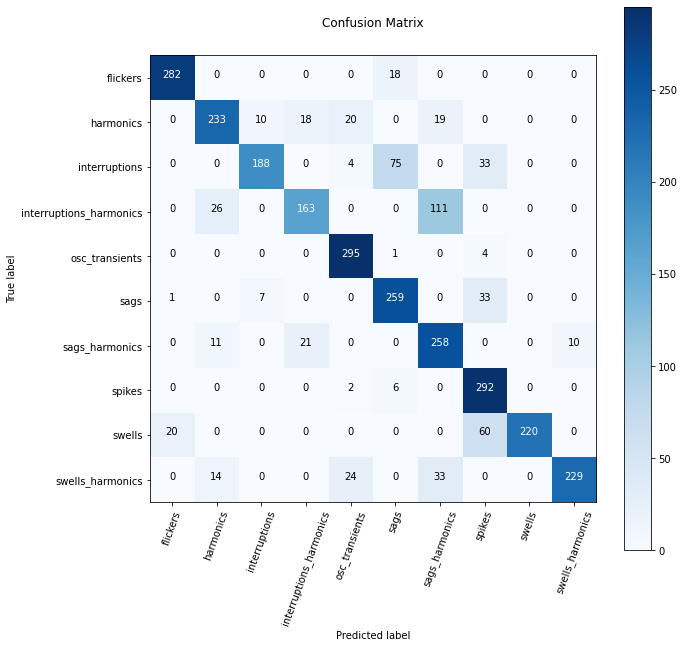

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
          y_pred=pred_classes,
          classes=class_names,
          figsize=(10, 10),
          text_size=10,
          norm=False,
          savefig=True)

In [ ]:
# Check f1 scores of the model.
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.9306930693069307,
  'recall': 0.94,
  'f1-score': 0.9353233830845772,
  'support': 300},
 '1': {'precision': 0.8204225352112676,
  'recall': 0.7766666666666666,
  'f1-score': 0.797945205479452,
  'support': 300},
 '2': {'precision': 0.9170731707317074,
  'recall': 0.6266666666666667,
  'f1-score': 0.7445544554455445,
  'support': 300},
 '3': {'precision': 0.806930693069307,
  'recall': 0.5433333333333333,
  'f1-score': 0.6494023904382471,
  'support': 300},
 '4': {'precision': 0.855072463768116,
  'recall': 0.9833333333333333,
  'f1-score': 0.9147286821705427,
  'support': 300},
 '5': {'precision': 0.7214484679665738,
  'recall': 0.8633333333333333,
  'f1-score': 0.7860394537177542,
  'support': 300},
 '6': {'precision': 0.6128266033254157,
  'recall': 0.86,
  'f1-score': 0.7156726768377254,
  'support': 300},
 '7': {'precision': 0.6919431279620853,
  'recall': 0.9733333333333334,
  'f1-score': 0.8088642659279779,
  'support': 300},
 '8': {'precision': 1.0,
  'rec

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'flickers': 0.9353233830845772,
 'harmonics': 0.797945205479452,
 'interruptions': 0.7445544554455445,
 'interruptions_harmonics': 0.6494023904382471,
 'osc_transients': 0.9147286821705427,
 'sags': 0.7860394537177542,
 'sags_harmonics': 0.7156726768377254,
 'spikes': 0.8088642659279779,
 'swells': 0.846153846153846,
 'swells_harmonics': 0.8497217068645639}

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
              "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
0,flickers,0.935323
4,osc_transients,0.914729
9,swells_harmonics,0.849722
8,swells,0.846154
7,spikes,0.808864
1,harmonics,0.797945
5,sags,0.786039
2,interruptions,0.744554
6,sags_harmonics,0.715673
3,interruptions_harmonics,0.649402


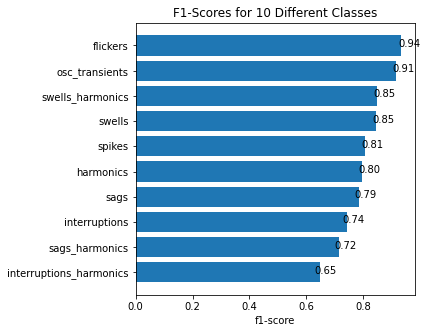

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

Finding the most wrong predictions as follows.

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in group_validation_dataset.list_files("/content/drive/MyDrive/target_dataset_10_classes(Jasper)/*/*.png", 
                            shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/drive/MyDrive/target_dataset_10_classes(Jasper)/flickers/flickers_sample0100.png',
 b'/content/drive/MyDrive/target_dataset_10_classes(Jasper)/flickers/flickers_sample0101.png',
 b'/content/drive/MyDrive/target_dataset_10_classes(Jasper)/flickers/flickers_sample0102.png',
 b'/content/drive/MyDrive/target_dataset_10_classes(Jasper)/flickers/flickers_sample0103.png',
 b'/content/drive/MyDrive/target_dataset_10_classes(Jasper)/flickers/flickers_sample0104.png',
 b'/content/drive/MyDrive/target_dataset_10_classes(Jasper)/flickers/flickers_sample0105.png',
 b'/content/drive/MyDrive/target_dataset_10_classes(Jasper)/flickers/flickers_sample0106.png',
 b'/content/drive/MyDrive/target_dataset_10_classes(Jasper)/flickers/flickers_sample0107.png',
 b'/content/drive/MyDrive/target_dataset_10_classes(Jasper)/flickers/flickers_sample0110.png',
 b'/content/drive/MyDrive/target_dataset_10_classes(Jasper)/flickers/flickers_sample0111.png']

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
            "y_true": y_labels,
            "y_pred": pred_classes,
            "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
            "y_true_classname": [class_names[i] for i in y_labels],
            "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/drive/MyDrive/target_dataset_10_cla...,0,0,0.875200,flickers,flickers
1,b'/content/drive/MyDrive/target_dataset_10_cla...,0,0,0.868384,flickers,flickers
2,b'/content/drive/MyDrive/target_dataset_10_cla...,0,0,0.851421,flickers,flickers
3,b'/content/drive/MyDrive/target_dataset_10_cla...,0,0,0.859126,flickers,flickers
4,b'/content/drive/MyDrive/target_dataset_10_cla...,0,0,0.527638,flickers,flickers


In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/drive/MyDrive/target_dataset_10_cla...,0,0,0.875200,flickers,flickers,True
1,b'/content/drive/MyDrive/target_dataset_10_cla...,0,0,0.868384,flickers,flickers,True
2,b'/content/drive/MyDrive/target_dataset_10_cla...,0,0,0.851421,flickers,flickers,True
3,b'/content/drive/MyDrive/target_dataset_10_cla...,0,0,0.859126,flickers,flickers,True
4,b'/content/drive/MyDrive/target_dataset_10_cla...,0,0,0.527638,flickers,flickers,True


In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
2922,b'/content/drive/MyDrive/target_dataset_10_cla...,9,4,0.896950,swells_harmonics,osc_transients,False
2952,b'/content/drive/MyDrive/target_dataset_10_cla...,9,4,0.891752,swells_harmonics,osc_transients,False
2806,b'/content/drive/MyDrive/target_dataset_10_cla...,9,1,0.785914,swells_harmonics,harmonics,False
2904,b'/content/drive/MyDrive/target_dataset_10_cla...,9,4,0.785602,swells_harmonics,osc_transients,False
1495,b'/content/drive/MyDrive/target_dataset_10_cla...,4,7,0.783809,osc_transients,spikes,False
2934,b'/content/drive/MyDrive/target_dataset_10_cla...,9,6,0.749442,swells_harmonics,sags_harmonics,False
1961,b'/content/drive/MyDrive/target_dataset_10_cla...,6,1,0.735903,sags_harmonics,harmonics,False
2017,b'/content/drive/MyDrive/target_dataset_10_cla...,6,1,0.729732,sags_harmonics,harmonics,False
2995,b'/content/drive/MyDrive/target_dataset_10_cla...,9,4,0.725064,swells_harmonics,osc_transients,False
2972,b'/content/drive/MyDrive/target_dataset_10_cla...,9,4,0.716487,swells_harmonics,osc_transients,False


In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

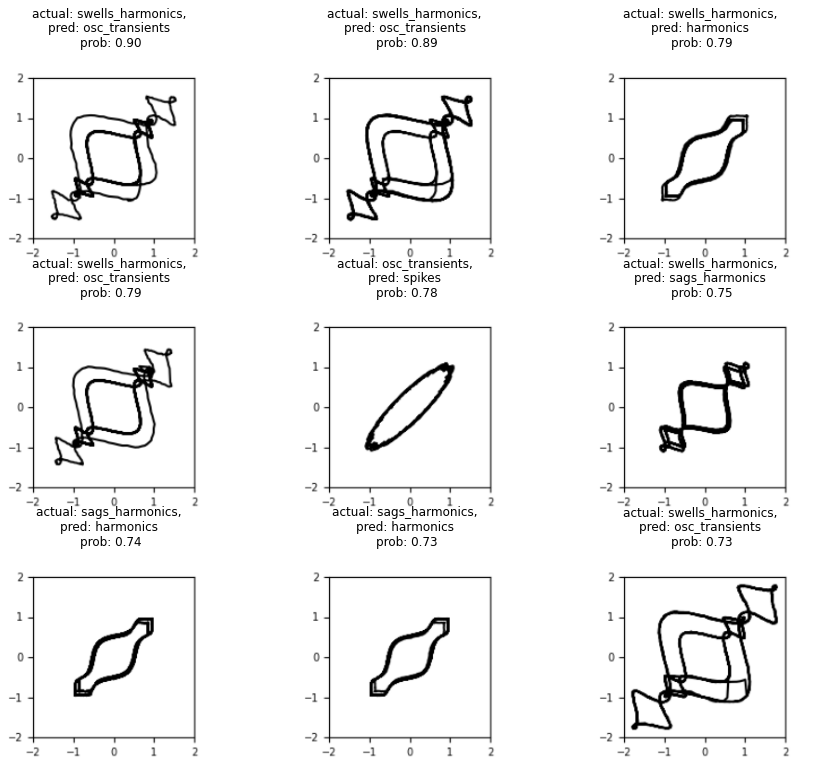

In [ ]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 0 # change the start index to view more
plt.figure(figsize=(15, 13))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, \npred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)